In [1]:
# import gymnasium as gym

from stable_baselines3 import DQN
from rl_envs.gym_grid_world_env import GridWorldEnv
import numpy as np
from tools.helper import *
from torch.utils.tensorboard.writer import SummaryWriter
import torch

from stable_baselines3.common.callbacks import BaseCallback




In [2]:
FORBIDDEN_REWARD = -1
HITWALL_REWARD = -1
TARGET_REWARD = 1

In [3]:
class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard.
    """

    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.total_reward = 0

    def _on_step(self) -> bool:
        # Log scalar value (here a random variable)
        self.total_reward += self.locals['rewards'][0]
        self.logger.record("total_reward", self.total_reward)
        return True


In [11]:
# 训练 stablebaseline3 的 DQN
env = GridWorldEnv(fixed_map = True,forbidden_grids=[(1,1),(1,2), (2,2),(3,1),(3,3),(4,1)], target_grids=[(3,2)], forbidden_reward=FORBIDDEN_REWARD, hit_wall_reward=HITWALL_REWARD, target_reward=TARGET_REWARD)

model = DQN("MultiInputPolicy", env, tensorboard_log="./runs/", verbose=1)
model.learn(total_timesteps=60_0000) # 所以训练无 fobidden 的地图需要 10_0000 次 (反正 10_000 是不够的) 
env.close()


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 1078, in _pydevd_bundle.pydevd_cython.PyDBFrame.trace_dispatch
  File "_pydevd_bundle/pydevd_cython.pyx", line 297, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "d:\apps\anaconda\envs\finRL_310\lib\site-packages\debugpy\_vendored\pydevd\pydevd.py", line 1976, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "d:\apps\anaconda\envs\finRL_310\lib\site-packages\debugpy\_vendored\pydevd\pydevd.py", line 2011, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
# vec_env.step(np.array(3))

# vec_env = model.get_env()
# vec_env = gym.make("CartPole-v1", render_mode = "human")
vec_env = GridWorldEnv(fixed_map = True, forbidden_grids=[(1,1),(1,2), (2,2),(3,1),(3,3),(4,1)], target_grids=[(3,2)], forbidden_reward=FORBIDDEN_REWARD, hit_wall_reward=HITWALL_REWARD, target_reward=TARGET_REWARD, render_mode="human")
# vec_env = GridWorldEnv(fixed_map = True, forbidden_grids=[(3,3),(4,2), (2,2),(3,1),(3,3),(4,1)], target_grids=[(1,2)], forbidden_reward=FORBIDDEN_REWARD, hit_wall_reward=HITWALL_REWARD, target_reward=TARGET_REWARD, render_mode="human")

obs, _ = vec_env.reset()
total_reward = 0
for i in range(500):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info  = vec_env.step(action)
    # vec_env.render()
    # if reward > 0:
        # break
    # VecEnv resets automatically
    total_reward += reward
    if terminated or truncated:
        obs, _ = vec_env.reset()
        print('reward: {}, distance: {}'.format(total_reward, info))
        total_reward = 0
        if truncated:
            print("TRUNCATE")
        else:
            print("TERMINATE")
vec_env.close()

reward: 10, distance: {'distance': 0.0}
TERMINATE


KeyboardInterrupt: 

In [ ]:
test_env = GridWorldEnv(fixed_map = True, forbidden_grids=[(1,1),(1,2), (2,2),(3,1),(3,3),(4,1)], target_grids=[(3,2)], forbidden_reward=FORBIDDEN_REWARD, hit_wall_reward=HITWALL_REWARD, target_reward=TARGET_REWARD, render_mode="human")


In [ ]:
test_obs = {'agent': np.array([0, 0]), 'target': np.array([[3, 2]]), 'forbidden': np.array([[1, 1],
       [1, 2],
       [2, 2],
       [3, 1],
       [3, 3],
       [4, 1]])}

Q = {}

observation, _ = model.q_net.obs_to_tensor(test_obs)

for y in range(env.size):
    for x in range(env.size):
       test_obs['agent'] = np.array([y,x])
       observation, _ = model.q_net.obs_to_tensor(test_obs)
       q_values = model.q_net(observation)
       Q[(y,x)] = q_values

print_by_dict(test_env, Q)


In [ ]:
V = {}
for state in Q.keys():
    V[state] = torch.max(Q[state]).item()
print_by_dict(test_env, V)


[ 9.07 9.15 9.21 9.32 9.41 ]
[ 8.93 9.07 9.33 9.42 9.50 ]
[ 8.85 8.89 10.00 9.51 9.59 ]
[ 8.88 9.98 9.89 9.99 9.69 ]
[ 8.82 9.87 10.01 9.88 9.79 ]


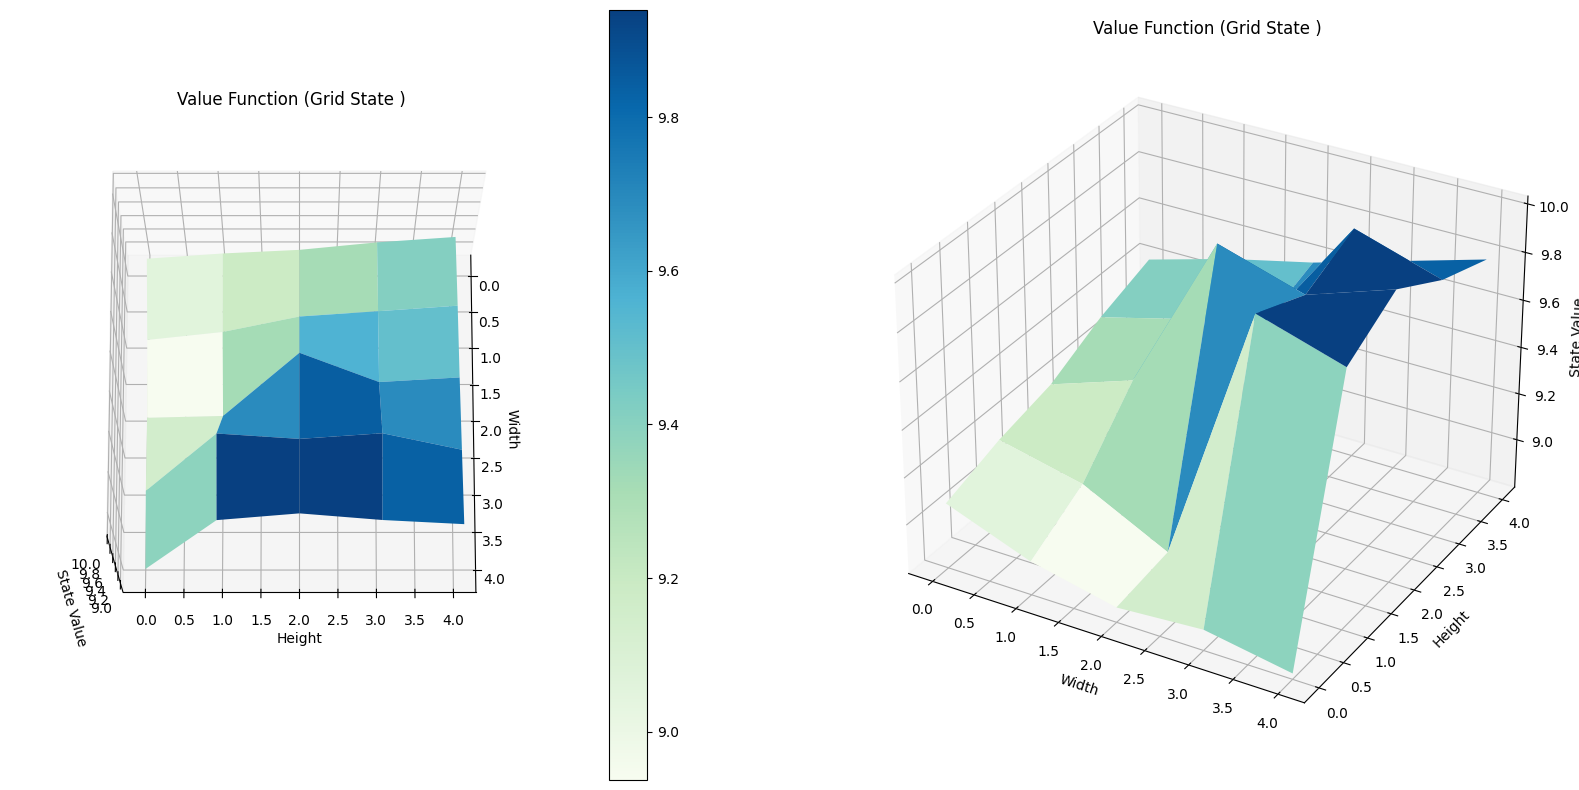

In [ ]:
plot_value_function(V)


In [ ]:
torch.save(model.q_net.state_dict(), "./model_saves/1hour-model-qnet-state-dict")
torch.save(model.q_net, "./model_saves/1hour-model-qnet-entire")